<h1 align='center'>Ben Prescott, Assignment 3 - Part 1, MSDS422, WI2021</h1>


Importing libraries 

In [10]:
import os
import re
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorboard
from pickleshare import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard
pd.set_option('display.max_columns', None) #Displays all columns for pandas output
sns.set(rc={'figure.figsize':(10,4)}) #Setting seaborn plot size standard
InteractiveShell.ast_node_interactivity = "all"


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Objective 0: Data Input, Verification, Transformation

In this section I'll be importing the data from the Pickle file, reviewing shape, reviewing frequency of labels, rescaling the data using MinMaxScaler, separated the labels and features into new arrays, then creating a 60/20/20 train/test/validation split. 

### Importing, Reviewing & Verifying

In [11]:
#Read pickle files into dataframe.
df = pd.read_pickle('/content/drive/MyDrive/MSDS422/Assignment3/assign-3-part-1-train.pickle')
#Verifying shape
print('Data Shape:',df.shape)

Data Shape: (40320, 786)


In [ ]:
df.head #excluding output due to PDF export issues/length requirements

Visually reviewing the different label values and their counts. Also helps to ensure there aren't any weird values out there.

array([2, 1, 0, 4, 6, 3, 9, 7, 5, 8])

(array([3976., 4489., 3998., 4181., 3918., 3636., 3981., 4236., 3888.,
        4017.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

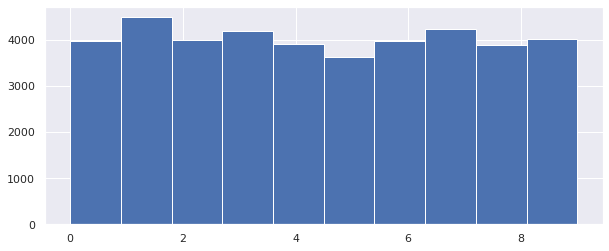

In [13]:
#Verifying image label values to ensure none are incorrect values
df['label'].unique()
#Histogram to visually verify
plt.hist(df['label'])

Creating a quick loop to check the Pixel features for incorrect values. Nothing is returned which shows there are no pixel values above 255 or below 0, which is accurate.

In [14]:
#Determine which columns have minimum values below 0 or maximum values above 255 
for col in df:
    if (col.startswith('pixel')) & (df[col].max() > 255):
        print('Columns with values above 255:',col)
    if (col.startswith('pixel')) & (df[col].min() < 0):
        print('Columns with values below 0:',col)        

### Rescaling Data w/ MinMaxScaler

Next I'll be rescaling the pixel features only with the MinMaxScaler. This can also be done by dividing each value by 255 (the max pixel value), but using the SKlearn algo for practice/familiarity.

In [23]:
#Loading MinMaxScaler algorithm
scaler = MinMaxScaler()
#Fitting the data to the algorithm
scaler.fit(df.iloc[:,1:785])
#Assigning the scaled data to a new variable named scaled_data
scaled_data = scaler.transform(df.iloc[:,1:785])
#Generating a new dataframe with the transformed pixels
dfscaled = pd.DataFrame(scaled_data, columns = df.iloc[:,1:785].columns)
dfscaled.iloc[0:2,153:157].head() #Reducing returned subset for PDF output

MinMaxScaler(copy=True, feature_range=(0, 1))

,pixel153,pixel154,pixel155,pixel156
0,0.988235,0.988235,0.580392,0.043137
1,0.529412,0.968627,0.988235,0.909804


### Separating Features & Labels

Now I'll be separating the features and original dataframe labels into two separate variables to prepare for train/test/validation split. I've also set the features dtype to float32 and labels to integer per the instructions. 

In [24]:
features = dfscaled
labels = df['label']
X = features.to_numpy(copy=True, dtype = 'float32') 
y = labels.to_numpy(copy=True, dtype = 'int')
X.shape
y.shape

(40320, 784)

(40320,)

### Train/Test/Validation Split (60/20/20)

Train/test/validation split. The goal is 60/20/20 train/test/validation. First train_test_split splits into a donor train pair and the test pair, with an initial 80/20 split. We now use the donor training set in the second train_test_split to create our validation set. We also decrease the ratio to 75/25 to provide us with the original 60/20/20 need.

In [25]:
#Creating train & test split
X_train_f , X_test , y_train_f , y_test = train_test_split(X, y, train_size = 0.80, test_size = 0.20,  random_state=33)
#Creating validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_f, y_train_f, train_size = 0.75, test_size = .25, random_state=34)
#Reviewing shapes of different objects
print(' X_train:',X_train.shape,'\n','y_train:',y_train.shape,'\n','X_test:',X_test.shape,'\n','y_test:',y_test.shape,'\n','X_valid:',X_valid.shape,'\n','y_valid:',y_valid.shape)

 X_train: (24192, 784) 
 y_train: (24192,) 
 X_test: (8064, 784) 
 y_test: (8064,) 
 X_valid: (8064, 784) 
 y_valid: (8064,)


## Objective 1: Train & Evaluate Four Version of a MLP That Predicts Digit Labels

In this section I'll be creating four different versions of MLPs. The goal is to predict the labels of different input digits.

To start I'm going to be creating the model checkpoint save location, as well as a callback for timing the model runtime. These will be used for each model moving forward.

Common hyperparameters that will be used are the callbacks, the optimizer (Adam), the loss function (sparse_categorical_crossentropy), the metric returned (accuracy), the number of epochs (10), batch size (32) and the activation types (selu / softmax).

The hyperparameters that will be varied are the number of hidden layers, the number of nodes in each layer, and the kernel initializer.

In [28]:
#Model Checkpoint location
cploc = '/content/drive/MyDrive/MSDS422/Assignment3/'
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

### Model 1

Training the first MLP. Providing comments to help provide context, but will remove comments to save space for future models, as they will follow the same format.

In [ ]:
#Adding checkpoint to save the best model based on validation accuracy
model_cp_save = keras.callbacks.ModelCheckpoint(cploc + 'model1.hdf5', save_best_only=True, monitor='val_accuracy')
model_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_time = TimingCallback()
optimizer = keras.optimizers.Adam()
#Creating the sequential model with 1 input layer, 2 hiden layers and 1 output layer
#Leveraging SeLU to provide a layer of internal normalization
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = X_train.shape[1:], name = 'InputLayer'),
    keras.layers.Dense(30, activation="selu", name = 'Layer1', kernel_initializer='lecun_normal'),
    keras.layers.Dense(20, activation="selu", name = 'Layer2', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation="softmax", name = 'OutputLayer')
])
#Compiling the model. Using sparse categorical crossentropy due to digits being from 0 - 9.
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
#Generating model summary
model1.summary()
#Fitting the model. Sticking with 20 epochs and a batch size of 32.
model1output = model1.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid), callbacks=[model_cp_save, model_time, model_stop], batch_size=32)
#Saving model training duration for later use
model1time = round(sum(model_time.logs),2)

In [30]:
#Predicting the first 5 rows of the test data using the newly trained model
y_proba = model1.predict(X_test[:5])
predicted = pd.DataFrame(y_proba.round(2))
actuals = pd.DataFrame(y_test[:5])
predicted['predicted_label'] = predicted.idxmax(axis=1)
predicted['actual_label'] = actuals
predicted

,0,1,2,3,4,5,6,7,8,9,predicted_label,actual_label
0,0.0,0.00,0.00,0.00,0.0,0.0,1.00,0.0,0.00,0.0,6,6
1,0.0,0.01,0.15,0.01,0.0,0.0,0.82,0.0,0.00,0.0,6,6
2,0.0,0.00,0.00,0.55,0.0,0.0,0.00,0.0,0.45,0.0,3,3
3,1.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0,0
4,0.0,0.00,0.00,0.00,0.0,1.0,0.00,0.0,0.00,0.0,5,5


In [68]:
#Creating a dataframe from the output history. Will be displaying a combined dataframe later.
t1 = pd.DataFrame(model1output.history)
t1 = t1.loc[t1['val_accuracy'][::-1].idxmax()]

### Model 2

Added an additional 2 hidden layers and modified the number of nodes per layer. All other hyperparameters remain the same.

In [ ]:
model_cp_save = keras.callbacks.ModelCheckpoint(cploc + 'model2.hdf5', save_best_only=True, monitor='val_accuracy')
model_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_time = TimingCallback()
optimizer = keras.optimizers.Adam()
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = X_train.shape[1:], name = 'InputLayer'),
    keras.layers.Dense(60,activation="selu", name = 'Layer1', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50,activation="selu", name = 'Layer2', kernel_initializer='lecun_normal'),
    keras.layers.Dense(40,activation="selu", name = 'Layer3', kernel_initializer='lecun_normal'),
    keras.layers.Dense(30, activation="selu", name = 'Layer4', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation="softmax", name = 'OutputLayer')
])
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
model2.summary()
model2output = model2.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid), callbacks = [model_cp_save, model_time, model_stop], batch_size = 32)
model2time = round(sum(model_time.logs),2)

In [65]:
y_proba = model2.predict(X_test[:5])
predicted = pd.DataFrame(y_proba.round(2))
actuals = pd.DataFrame(y_test[:5])
predicted['predicted_label'] = predicted.idxmax(axis=1)
predicted['actual_label'] = actuals
predicted

,0,1,2,3,4,5,6,7,8,9,predicted_label,actual_label
0,0.0,0.0,0.00,0.0,0.03,0.0,0.97,0.0,0.0,0.0,6,6
1,0.0,0.0,0.02,0.0,0.00,0.0,0.97,0.0,0.0,0.0,6,6
2,0.0,0.0,0.00,1.0,0.00,0.0,0.00,0.0,0.0,0.0,3,3
3,1.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0,0
4,0.0,0.0,0.00,0.0,0.00,1.0,0.00,0.0,0.0,0.0,5,5


In [67]:
#Creating a dataframe from the output history
t2 = pd.DataFrame(model2output.history)
t2 = t2.loc[t2['val_accuracy'][::-1].idxmax()]

### Model 3

Keeping the number of hidden layers the same but adjusting the number of nodes per layer to examine the change.

In [ ]:
model_cp_save = keras.callbacks.ModelCheckpoint(cploc + 'model3.hdf5', save_best_only=True, monitor='val_accuracy')
model_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_time = TimingCallback()
optimizer = keras.optimizers.Adam()

model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = X_train.shape[1:], name = 'InputLayer'),
    keras.layers.Dense(500,activation="selu", name = 'Layer1', kernel_initializer='lecun_normal'),
    keras.layers.Dense(200,activation="selu", name = 'Layer2', kernel_initializer='lecun_normal'),
    keras.layers.Dense(200,activation="selu", name = 'Layer3', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation="selu", name = 'Layer4', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation="softmax", name = 'OutputLayer')
])

model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

model3.summary()
model3output = model3.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid), callbacks = [model_cp_save, model_time, model_stop], batch_size = 32)
model3time = round(sum(model_time.logs),2)

In [69]:
X_new = X_test[:5]
y_proba = model3.predict(X_new)
predicted = pd.DataFrame(y_proba.round(2))
actuals = pd.DataFrame(y_test[:5])
predicted['predicted_label'] = predicted.idxmax(axis=1)
predicted['actual_label'] = actuals
predicted

,0,1,2,3,4,5,6,7,8,9,predicted_label,actual_label
0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,6,6
1,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,6,6
2,0.0,0.0,0.0,0.89,0.0,0.0,0.0,0.0,0.1,0.0,3,3
3,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,5,5


In [70]:
#Creating a dataframe from the output history
t3 = pd.DataFrame(model3output.history)
t3 = t3.loc[t3['val_accuracy'][::-1].idxmax()]

### Model 4

Adding an additional 4 hidden layers to total 1 input layer, 8 hidden layers and 1 output layer. Varying the number of nodes per layer as well. Keeping all other settings the same.

In [ ]:
model_cp_save = keras.callbacks.ModelCheckpoint(cploc + 'model4.hdf5', save_best_only=True, monitor='val_accuracy')
model_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_time = TimingCallback()
optimizer = keras.optimizers.Adam()

model4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = X_train.shape[1:], name = 'InputLayer'),
    keras.layers.Dense(600,activation="selu", name = 'Layer1', kernel_initializer='lecun_normal'),
    keras.layers.Dense(200,activation="selu", name = 'Layer2', kernel_initializer='lecun_normal'),
    keras.layers.Dense(500,activation="selu", name = 'Layer3', kernel_initializer='lecun_normal'),
    keras.layers.Dense(300,activation="selu", name = 'Layer4', kernel_initializer='lecun_normal'),
    keras.layers.Dense(400,activation="selu", name = 'Layer5', kernel_initializer='lecun_normal'),
    keras.layers.Dense(400,activation="selu", name = 'Layer6', kernel_initializer='lecun_normal'),
    keras.layers.Dense(100,activation="selu", name = 'Layer7', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation="selu", name = 'Layer8', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation="softmax", name = 'OutputLayer')
])

model4.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

model4.summary()

model4output = model4.fit(X_train, y_train, epochs=20, validation_data = (X_valid, y_valid), callbacks = [model_cp_save, model_time, model_stop], batch_size = 32)

model4time = round(sum(model_time.logs),2)

In [72]:
X_new = X_test[:5]
y_proba = model4.predict(X_new)
predicted = pd.DataFrame(y_proba.round(2))
actuals = pd.DataFrame(y_test[:5])
predicted['predicted_label'] = predicted.idxmax(axis=1)
predicted['actual_label'] = actuals
predicted

,0,1,2,3,4,5,6,7,8,9,predicted_label,actual_label
0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,6,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.0,0.01,0.0,6,6
2,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,3,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.00,0.0,5,5


In [75]:
#Creating a dataframe from the output history
t4 = pd.DataFrame(model3output.history)
t4 = t4.loc[t4['val_accuracy'][::-1].idxmax()]

loss            0.060591
accuracy        0.981605
val_loss        0.147407
val_accuracy    0.968626
Name: 9, dtype: float64

#### Evaluating Model Results

Now that I have trained the four models I'll take each model's best epoch and combine them into a dataframe. I'll then decide which model to use to predict my test values. 

Based on the output of the model history's best epoch (based on validation accuracy) the best model looks to be Model 3. Both Model 3 and 4 have exactly the same metric values. However, Model 4 is more complex/resource intensive and may result in a risk of overfitting with a greater number of epochs, so I'll be going with Model 3 to provide my predictions

In [87]:
tout = pd.concat([t1,t2,t3,t4], axis=1)
tout.columns = ['Model 1','Model 2','Model 3', 'Model 4']
tout.loc['training_time'] = np.array([model1time,model2time,model3time,model4time])
tout.loc['num_epochs'] = [len(model1output.history['loss']),len(model2output.history['loss']),len(model3output.history['loss']),len(model4output.history['loss'])]
tout.loc['num_layers'] = [len(model1.layers),len(model2.layers),len(model3.layers),len(model4.layers)]
tout.loc['num_params'] = [model1.count_params(), model2.count_params(), model3.count_params(), model4.count_params()]
tout

,Model 1,Model 2,Model 3,Model 4
loss,0.082856,0.077477,0.060591,6.059139e-02
accuracy,0.974578,0.974165,0.981605,9.816055e-01
val_loss,0.143516,0.129277,0.147407,1.474069e-01
val_accuracy,0.958953,0.960938,0.968626,9.686260e-01
training_time,18.660000,19.460000,19.650000,3.581000e+01
num_epochs,10.000000,10.000000,10.000000,1.600000e+01
num_layers,4.000000,6.000000,6.000000,1.000000e+01
num_params,24380.000000,53730.000000,543460.000000,1.168460e+06


Plotting each model's metrics history to further validate the decision for model 3. Model 4 looks to be potentially increasing the loss/decreasing accuracy past epoch #9 - another reason not to use it.

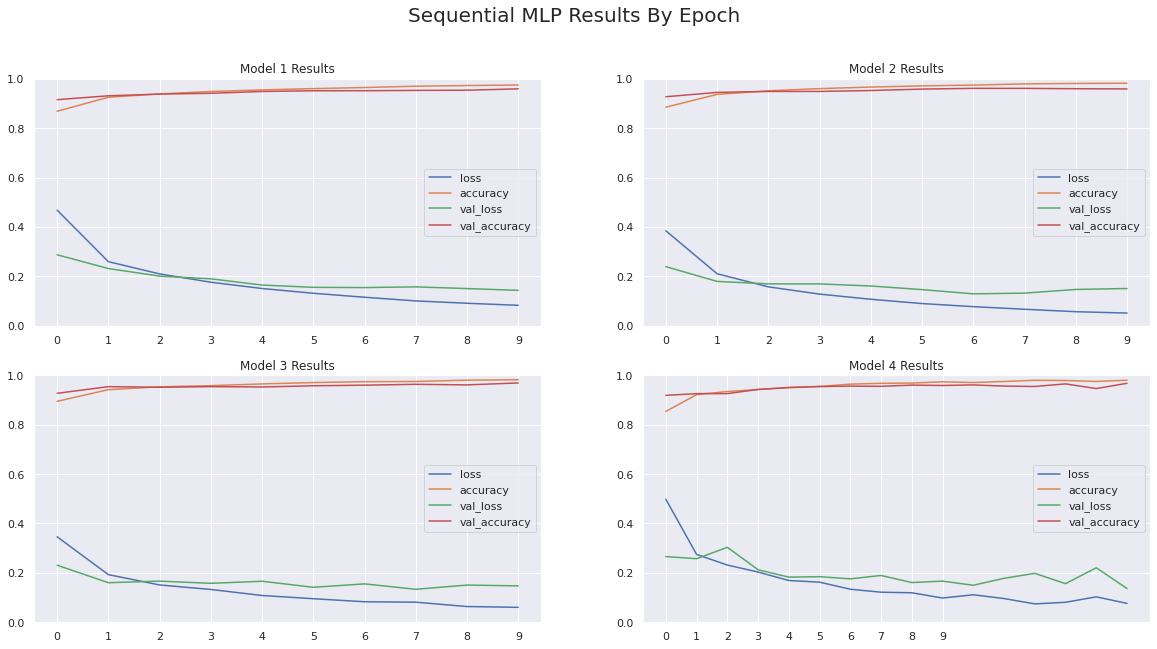

In [84]:
fig, ((ax1, ax2), (ax3 ,ax4)) = plt.subplots(2, 2,  figsize=(20,10))
fig.suptitle('Sequential MLP Results By Epoch', fontsize = 20)
ax1.plot(pd.DataFrame(model1output.history))
ax1.set_title('Model 1 Results')
ax1.set_ylim(0,1)
ax1.set_xticks(np.arange(0,10))
ax1.legend(pd.DataFrame(model1output.history), loc="center right")
ax2.plot(pd.DataFrame(model2output.history))
ax2.set_title('Model 2 Results')
ax2.set_ylim(0,1)
ax2.set_xticks(np.arange(0,10))
ax2.legend(pd.DataFrame(model1output.history), loc="center right")
ax3.plot(pd.DataFrame(model3output.history))
ax3.set_title('Model 3 Results')
ax3.set_ylim(0,1)
ax3.set_xticks(np.arange(0,10))
ax3.legend(pd.DataFrame(model1output.history), loc="center right")
ax4.plot(pd.DataFrame(model4output.history))
ax4.set_title('Model 4 Results')
ax4.set_ylim(0,1)
ax4.set_xticks(np.arange(0,10))
ax4.legend(pd.DataFrame(model1output.history), loc="center right")
plt.show;

#### Predicting Test Values w/ Model 3

Now that I've chosen Model 3 I'll be predicting labels using the X_test data. I'll then take the information and add it to a dataframe so that we can see the probability of each number, as well as the overall predicted value vs the true label.

I chose a mostly random subset of data to show from the dataframe, with the intention of finding one predicted label that was incorrect. Row 215 shows that it was 100% confident it was a 5, but the actual label from the y_test data was a 9.

Overall, the model does a pretty good job of predicting the values and having a usually high confidence 

In [94]:
y_proba = model3.predict(X_test)
predicted = pd.DataFrame(y_proba.round(2))
actuals = pd.DataFrame(y_test)
predicted['predicted_label'] = predicted.idxmax(axis=1)
predicted['actual_label'] = actuals
predicted[200:220]

,0,1,2,3,4,5,6,7,8,9,predicted_label,actual_label
200,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.0,0.00,8,8
201,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.0,0.0,0.00,3,3
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1.00,9,9
203,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1,1
204,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.0,0.0,0.00,6,6
205,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.0,0.00,4,4
206,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1,1
207,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.00,7,7
208,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.0,0.00,4,4
209,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.0,0.0,0.16,4,4
